# Задача
В этой работе вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week

Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

В этой задаче для обучения будут использовать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

# Решение

Загрузите набор данных *data.adult.csv* с помощью `pandas` (скачать можно [здесь](https://drive.google.com/file/d/1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf/view?usp=sharing), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [ ]:
!gdown 1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf

Downloading...
From: https://drive.google.com/uc?id=1Lo47fXx1RrJG3v9E-Gck1T45n5bJ_SJf
To: /content/data.adult.csv
100% 1.54M/1.54M [00:00<00:00, 141MB/s]


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("data.adult.csv")
print(df.info())
df.sample(n = 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB
None


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
14208,23,Private,197207,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,<=50K
791,45,Private,248993,HS-grad,9,Married-spouse-absent,Farming-fishing,Other-relative,Black,Male,0,0,40,<=50K
335,30,Self-emp-not-inc,226535,7th-8th,4,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,40,<=50K
1983,18,Private,434268,11th,7,Never-married,Adm-clerical,Own-child,White,Female,0,0,15,<=50K
9687,22,Private,341368,Some-college,10,Never-married,Other-service,Not-in-family,White,Male,0,0,50,<=50K


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем:
1. Проверьте есть ли в данных пропущенные значения (здесь они обозначены как "?"). Удалите из выборки все объекты с пропусками.
2. Выделите 60% выборки для обучения и дальнейшего анализа.
3. Обратите внимание, что не все признаки являются вещественными (числовыми). Сначала их необходимо проанализировать и по необходимости предобработать. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную и преобразуйте к бинарному формату (НЕ забудьте удалить ее из датасета, когда будете обучать модель).


In [4]:
#1
# print(df.isin(["?"]).sum())
df = df[~(df =="?").any(axis=1)]
# df.isin(["?"]).sum()

❔❓❔ я же правильно понимаю, что если все преобразования, которые я делаю с выборкой, это просто OneHotEncoding/get_dummies и выбрасывание лишних строк, то смысла делать их по отдельности с test и train нет (ну если только в какой-то из частей вдруг не окажется одного из новых получившихся бинарных признаков.. Но в таком случае вообще надо отдельно думать)

In [6]:
X = df[df.columns[:-1]]
X = pd.get_dummies(X, columns = ['workclass', 'education', "marital-status","occupation", "relationship", "race", "sex"], dtype=int)
y = np.array(df[df.columns[-1]]).reshape(-1,1)
y = np.array([[1 if x=='>50K' else 0 for x in y]]).reshape(-1,1)
print(X.shape, y.shape)


(15347, 63) (15347, 1)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.6,
                                                    random_state=1)
print(X_train.shape, y_train.shape)

(9208, 63) (9208, 1)


При обучении алгоритмов стоит обращать внимание не только на их качество, но и каким образом они работают с данными. Давайте посмотрим на значения самих признаков.

Что можете сказать о разбросе данных и сбалансированности выборки? В каком диапазоне лежат исследуемые признаки?

In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,15347.000000,1.534700e+04,15347.000000,15347.000000,15347.000000,15347.000000
mean,38.495537,1.891545e+05,10.150844,1053.294129,88.667492,40.892422
std,13.110063,1.062935e+05,2.553045,7001.715695,405.368093,12.031182
min,17.000000,1.930200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.168125e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779370e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.368550e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,3900.000000,99.000000


## Добавление категориальных признаков

Добавим к предобработанным вещественным признакам категориальные. Но для начала их тоже необходимо предобработать.

Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) / [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) из sklearn).

После преобразования категориальных признаков, добавьте их к вещественным предобработанным данным для обучения.

>PS Напоминаю, что важно удалить колонку с целевым значением

In [ ]:
# your code here

## Обучение классификаторов

В начале посмотрим, как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 2 алгоритма:
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Для начала обучим  выберем один гиперпараметр, который будем оптимизировать, — глубина дерева (*max_depth*).

Остальные параметры оставляйте в значениях по умолчанию.

Для каждого алгоритма подберите оптимальные значения указанных гиперпараметров. Постройте график среднего значения качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал.

Что вы можете сказать о получившихся графиках? Какой алгоритм справился лучше? Какой быстрее? Почему?

# Насчет доверительного интервала :
❔❔❔    Честно, не помню, чтобы в лекциях говорилось что-то про доверительные интервалы.. Из курса мат.статистики мне известно, что это интервал, который содержит внутри себя параметр с какой-либо вероятностью( 0.9 0.95 0.99 ..) Получается тут мне нужно построить интервал для гиперпараметра (глубина дерева, max_depth)? Но ведь мы его подбираем просто перебором, без каких-либо статистических оценок и тут для меня теряется смысл этого доверительного интервала. Ведь ,насколько я понимаю, он должен строиться на основании какой-либо оценки (ОММ/ ОМП/ байес..)
Хочется понять что тут от меня хотят)


100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


{DecisionTree}: best depth = 6 with best cvs core = 0.8413332224555766


100%|██████████| 20/20 [01:11<00:00,  3.58s/it]


{RandomForest}: best depth = 13 with best cvs core = 0.8494768398187975


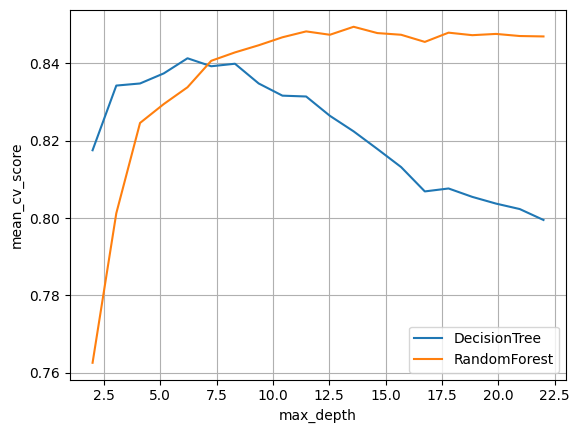

In [8]:
start = 2
n = 22
cv_scores=[]
best_depth = 1
best_cv_score = 0

for i in tqdm(range(start, n)):
    d3 = DecisionTreeClassifier(max_depth=i, random_state=1)
    cv_score = np.mean(cross_val_score(d3, X_train, y_train.ravel()))
    cv_scores.append(cv_score)
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_depth = i

plt.plot(np.linspace(start, n, n-start), cv_scores, label="DecisionTree")
plt.xlabel("max_depth")
plt.ylabel("mean_cv_score")


print("{DecisionTree}: best depth =", best_depth, "with best cvs core =", best_cv_score)
d3_depth = best_depth

start = 2
n = 22
cv_scores=[]
best_depth = 1
best_cv_score = 0

for i in tqdm(range(start, n)):
    rf = RandomForestClassifier(max_depth=i, random_state=1)
    cv_score = np.mean(cross_val_score(rf, X_train, y_train.ravel()))
    cv_scores.append(cv_score)
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_depth = i

plt.plot(np.linspace(start, n, n-start), cv_scores, label="RandomForest")
plt.legend()
plt.grid()


print("{RandomForest}: best depth =", best_depth, "with best cvs core =", best_cv_score)
rf_depth = best_depth

Далее произведем подбор других гиперпараметров алгоритмов. Начнет со случайного леса. Для начала подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев. Подберите количество деревьев, начиная с которого качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества деревьев разных размеров, состоящих из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте подобранное количество деревьев.

❔❓❔  "Подберите количество деревьев, начиная с которого ***качество на кросс-валидации стабилизируется***.  ... стоящих из деревьев построенного леса"

•	Не понимаю, как иначе я могу сразу выбрать “ лес с ***максимальным интересным количеством*** ”, если не перебором, ведь “интересность” оценивается стабилизацией кросс-валидации (вдруг я возьму значение на котором cv_score всё ещё не стабилизировался). А для того чтобы понять это, я должен последовательно на графике наблюдать эту стабилизацию (в моём понимании), т.е. мне так или иначе надо посмотреть все деревья до этого максимально интересного числа..

•	cv_score ведь каждый раз заново обучает модели на k-1 фолдах (если это не так, то я дико извиняюсь и дальше читать мой вопрос наверное нет смысла).
*sklearn.model_selection.cross_val_score(model,X,y,..)*

А если это так, то мы в любом случае обучим каждое подмножество леса..
В общем я опять не понимаю, что тут имеют в виду, если мы оцениваем качество по cv_score, который и так каждый раз обучает модель..


In [ ]:
# найти случайный лес с максимальным интересным количеством деревьев не легче вроде..

100%|██████████| 80/80 [02:44<00:00,  2.05s/it]


{RandomForest}: best n_estimators = 65 with best cvs core = 0.8482822499455931
берем n_estimators=85
CPU times: user 2min 42s, sys: 482 ms, total: 2min 43s
Wall time: 2min 44s


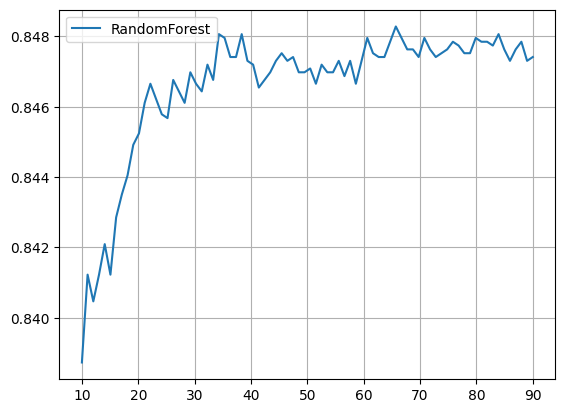

In [10]:
%%time
start = 10
n = 90
cv_scores=[]
best_n_est = 1
best_cv_score = 0

for i in tqdm(range(start, n)):
    rf = RandomForestClassifier(max_depth=rf_depth, n_estimators=i, random_state=1)
    cv_score = np.mean(cross_val_score(rf, X_train, y_train.ravel()))
    cv_scores.append(cv_score)
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_n_est = i

plt.plot(np.linspace(start, n, n-start), cv_scores, label="RandomForest")
plt.legend()
plt.grid()

print("{RandomForest}: best n_estimators =", best_n_est, "with best cvs core =", best_cv_score)
print("берем n_estimators=85")
rf_n_est=60

Теперь подберите следующие оптимальные параметры:
- максимальная глубина решающего дерева (*max_depth*)
- функция оценки качества разбиения (*criterion*)
- максимальное количесво учитываемых признаков при разбиении (*max_features*)

Остальные параметры оставляйте по умолчанию, за исключением парамтра `n_estimators` для случайного леса, выбранного на предыдущем шаге.

Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

In [11]:
#finding criterion
print(d3_depth)
d3 = DecisionTreeClassifier(max_depth=d3_depth, criterion='gini', random_state=1)
cv_score = np.mean(cross_val_score(d3, X_train, y_train.ravel()))
print("{d3 gini}", cv_score)
d3 = DecisionTreeClassifier(max_depth=d3_depth, criterion='entropy', random_state=1)
cv_score = np.mean(cross_val_score(d3, X_train, y_train.ravel()))
print("{d3 entropy}", cv_score)
d3 = DecisionTreeClassifier(max_depth=d3_depth, criterion='log_loss', random_state=1)
cv_score = np.mean(cross_val_score(d3, X_train, y_train.ravel()))
print("{d3 log_loss}", cv_score)

print(rf_depth)
rf = RandomForestClassifier(max_depth=rf_depth, n_estimators=rf_n_est, criterion='gini', random_state=1)
cv_score = np.mean(cross_val_score(rf, X_train, y_train.ravel()))
print("{rf gini}", cv_score)
rf = RandomForestClassifier(max_depth=rf_depth, n_estimators=rf_n_est, criterion='entropy', random_state=1)
cv_score = np.mean(cross_val_score(rf, X_train, y_train.ravel()))
print("{rf entropy}", cv_score)
frd3 = RandomForestClassifier(max_depth=rf_depth, n_estimators=rf_n_est, criterion='log_loss', random_state=1)
cv_score = np.mean(cross_val_score(rf, X_train, y_train.ravel()))
print("{rf log_loss}", cv_score)

6
{d3 gini} 0.8413332224555766
{d3 entropy} 0.8399215952714176
{d3 log_loss} 0.8399215952714176
13
{rf gini} 0.8473049922709948
{rf entropy} 0.8483910634887215
{rf log_loss} 0.8483910634887215


>нет особого смысла брать что-то отличное от gini

100%|██████████| 61/61 [00:08<00:00,  6.79it/s]


{DecisionTree}: best n = 55 with best cvs core = 0.8427450265723262
для дерева, вероятно, достаточно будет и 40 фичей, т.к. там cv_score уже начинает стабилизироваться


100%|██████████| 31/31 [02:51<00:00,  5.52s/it]


{RandomForest}: best n = 14 with best cvs core = 0.8492602743280837
для леса, вероятно, достаточно будет и 7-8 фичей, т.к. там cv_score уже начинает стабилизироваться
CPU times: user 2min 58s, sys: 430 ms, total: 2min 59s
Wall time: 3min


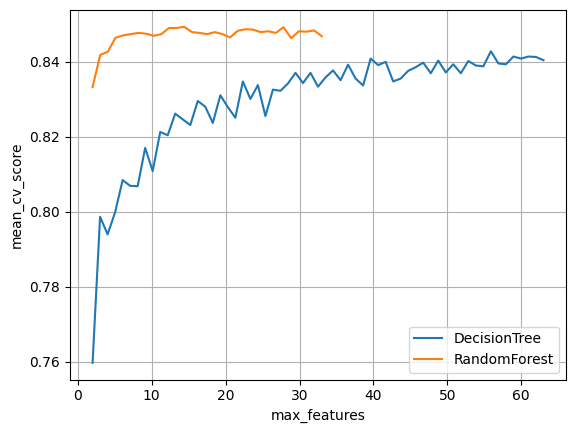

In [15]:
%%time
start = 2
n = X_train.shape[1]
cv_scores=[]
best_n_fea = 1
best_cv_score = 0

for i in tqdm(range(start, n)):
    d3 = DecisionTreeClassifier(max_features=i, max_depth=d3_depth, random_state=1)
    cv_score = np.mean(cross_val_score(d3, X_train, y_train.ravel()))
    cv_scores.append(cv_score)
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_n_fea = i

plt.plot(np.linspace(start, n, n-start), cv_scores, label="DecisionTree")
plt.xlabel("max_features")
plt.ylabel("mean_cv_score")


print("{DecisionTree}: best n =", best_n_fea, "with best cvs core =", best_cv_score)
d3_n_fea = best_n_fea
print("для дерева, вероятно, достаточно будет и 40 фичей, т.к. там cv_score уже начинает стабилизироваться")

start = 2
n = 33
cv_scores=[]
best_n_fea = 1
best_cv_score = 0

for i in tqdm(range(start, n)):
    rf = RandomForestClassifier(max_features=i, max_depth=rf_depth, n_estimators = rf_n_est, random_state=1)
    cv_score = np.mean(cross_val_score(rf, X_train, y_train.ravel()))
    cv_scores.append(cv_score)
    if cv_score > best_cv_score:
        best_cv_score = cv_score
        best_n_fea = i

plt.plot(np.linspace(start, n, n-start), cv_scores, label="RandomForest")
plt.legend()
plt.grid()


print("{RandomForest}: best n =", best_n_fea, "with best cvs core =", best_cv_score)
rf_n_fea = best_n_fea
print("для леса, вероятно, достаточно будет и 7-8 фичей, т.к. там cv_score уже начинает стабилизироваться")

По итогу берем:
>для дерева (max_features=40, max_depth=6, criterion='gini')

>для случайного леса (max_features=8,  max_depth=13, criterion='gini', n_estimators = 60)

## Сравнение результатов

Сравните результаты алгоритмво. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

❔❓❔    Не помню в лекциях упоминания графика вида "ящик с усами" в разрезе понятия скорости обучения в зависимости от гиперпараметров(не укладывается в голове как он тут поможет, обычно мы строили его по выборке, выискивая выбросы и т.д…).
 Да и так понятно ведь, что чем больше гиперпарметры( глубина, количество деревьев, фичей), тем дольше будет обучаться модель, разве это не так (по крайней мере подбирая эти параметра последовательным перебором, я заметил данную закономерность)?

In [ ]:
# your code here

## Тестирование всех модели

Протестируйте последние построенные модели (наилучшее решающее дерево и наилучший случайный лес) на данных, которые были отложены для теста (их должно было остаться 40%). Не забудьте про все необходимые преобразования.

In [ ]:
# your code here

In [23]:
d3 = DecisionTreeClassifier(max_features=40, max_depth=6, criterion='gini').fit(X_test, y_test.ravel())
y_pred = d3.predict(X_test)
print(f"[d3] accuracy: {accuracy_score(y_pred, y_test)}, f1: {f1_score(y_pred, y_test)}, cv score: {np.mean(cross_val_score(d3, X_test, y_test.ravel()))}")


rf = RandomForestClassifier(max_features=8, max_depth=13, criterion='gini', n_estimators = 60).fit(X_test, y_test.ravel())
y_pred = rf.predict(X_test)
print(f"[rf] accuracy: {accuracy_score(y_pred, y_test)}, f1: {f1_score(y_pred, y_test)}, cv score: {np.mean(cross_val_score(rf, X_test, y_test.ravel()))}")

[d3] accuracy: 0.8561654992669816, f1: 0.6615561517822921, cv score: 0.8416697859507446
[rf] accuracy: 0.9097572894608242, f1: 0.8027065527065527, cv score: 0.8550264276365915


##👑RandomForest👑 is a CHAMPION🏆🏆🏆🥇